# 1. Problem Definition and Requirements

**Objective:**  
Predict travel time (duration in seconds) for ride trips given start and end locations (specified in WGS84 coordinates) and a departure datetime.

**Datasets:**  
- **train.csv:** Contains columns:
  - `row_id`, `start_lng`, `start_lat`, `end_lng`, `end_lat`, `datetime`, `duration`
- **test.csv:** Contains columns:
  - `row_id`, `start_lng`, `start_lat`, `end_lng`, `end_lat`, `datetime`

**Evaluation Metric:**  
Root Mean Squared Error (RMSE) computed as:  
```python
RMSE = sqrt(mean_squared_error(prediction, ground_truth))

# 2. Data Ingestion and Exploration

In this step, we load the training and test datasets, inspect their structure, and conduct initial exploratory analysis to understand the underlying data characteristics. This exploration helps identify potential issues (such as missing values and outliers) and informs subsequent feature engineering and modeling steps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from pyproj import Geod

from sklearn.metrics.pairwise import haversine_distances
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Data Loading

- Read the `train.csv` and `test.csv` files using pandas.
- Parse the `datetime` column into datetime objects for easier temporal manipulation later.

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
test = pd.read_csv('test.csv', parse_dates=['datetime'])

## Initial Inspection

- Display the first few rows of each dataset with `.head()` to get an overview.
- Use `.info()` to review data types and non-null counts, which aids in detecting missing or inconsistent data.
- Generate summary statistics with `.describe()` to understand the distribution, central tendency, and spread of numerical features.

In [3]:
train.head()

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0
4,4,-74.008728,40.714317,-74.006432,40.731720,2015-01-21 12:14:45,582.0


In [4]:
test.head()

,row_id,start_lng,start_lat,end_lng,end_lat,datetime
0,0,-74.001488,40.726170,-73.962097,40.764500,2015-06-27 23:58:40
1,1,-122.454077,37.774170,-122.428070,37.777023,2012-09-10 01:32:00
2,2,-73.976753,40.751575,-73.789917,40.646965,2015-09-26 11:24:54
3,3,-122.405967,37.778165,-122.430198,37.759545,2012-09-03 05:21:00
4,4,-73.988197,40.750187,-73.872711,40.774292,2015-02-12 09:48:39


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146001 entries, 0 to 146000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   row_id     146001 non-null  int64         
 1   start_lng  145601 non-null  float64       
 2   start_lat  146001 non-null  float64       
 3   end_lng    146001 non-null  float64       
 4   end_lat    145401 non-null  float64       
 5   datetime   146001 non-null  datetime64[ns]
 6   duration   146001 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 7.8 MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   row_id     30000 non-null  int64         
 1   start_lng  30000 non-null  float64       
 2   start_lat  30000 non-null  float64       
 3   end_lng    30000 non-null  float64       
 4   end_lat    30000 non-null  float64       
 5   datetime   30000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.4 MB


In [7]:
train.describe()

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
count,146001.000000,145601.000000,146001.000000,146001.000000,145401.000000,146001,146001.000000
mean,73000.000000,-86.465695,39.913703,-87.177163,39.922772,2014-09-12 22:40:34.780385280,1063.222314
min,0.000000,-122.515832,37.459648,-122.634420,37.225640,2012-09-01 00:00:00,0.000000
25%,36500.000000,-122.393532,37.798430,-122.392458,37.800318,2012-09-13 21:16:00,382.000000
50%,73000.000000,-73.989830,40.741089,-73.988754,40.740990,2015-04-16 03:37:24,631.000000
75%,109500.000000,-73.974190,40.762104,-73.971245,40.762669,2015-08-19 00:46:17,1020.000000
max,146000.000000,74.100212,40.994354,-50.336068,41.005390,2016-01-01 03:49:39,42168.000000
std,42147.002663,25.468467,1.339508,22.225753,1.336437,NaN,3305.905829


## Missing Values Analysis

- Identify missing data with `.isnull().sum()`, ensuring data integrity and determining if imputation or cleaning is required.

In [8]:
train.isnull().sum()

row_id         0
start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
duration       0
dtype: int64

In [9]:
test.isnull().sum()

row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
dtype: int64

In [10]:
train['missing_coords'] = train[['start_lng', 'end_lat']].isnull().any(axis=1)
missing_count = train['missing_coords'].sum()
total_rows = train.shape[0]
print(f"Missing coordinate rows: {missing_count} out of {total_rows}")
print("\nSummary statistics for 'duration' by missing indicator:")
print(train.groupby('missing_coords')['duration'].describe())

Missing coordinate rows: 1000 out of 146001

Summary statistics for 'duration' by missing indicator:
                   count         mean          std    min    25%    50%  \
missing_coords                                                            
False           145001.0  1065.804932  3316.873211    0.0  383.0  631.0   
True              1000.0   688.740000   506.019830  120.0  360.0  600.0   

                   75%      max  
missing_coords                   
False           1020.0  42168.0  
True             840.0   6180.0  


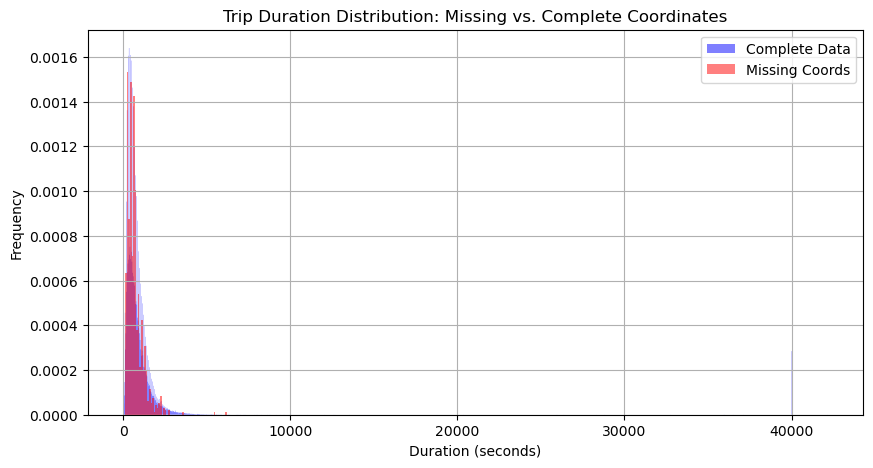

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(train.loc[~train['missing_coords'], 'duration'], bins='auto', alpha=0.5, label='Complete Data', color='blue', histtype='stepfilled', density=True)
plt.hist(train.loc[train['missing_coords'], 'duration'], bins='auto', alpha=0.5, label='Missing Coords', color='red', histtype='stepfilled', density=True)
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Trip Duration Distribution: Missing vs. Complete Coordinates")
plt.legend()
plt.grid()
plt.show()

In [12]:
train.dropna(subset=['missing_coords'], inplace=True)

## Exploratory Visualizations

- Trip Duration Distribution: A histogram (with kernel density estimation) is plotted to understand the distribution of trip durations, highlighting skewness or outliers.
- Geospatial Distribution: Scatter plots of the start and end locations reveal spatial patterns or clustering, which might indicate regional trends or anomalies.
- Temporal Patterns: Extracting the hour from the `datetime` field and plotting trip counts by hour provides insight into peak travel times and daily usage patterns.


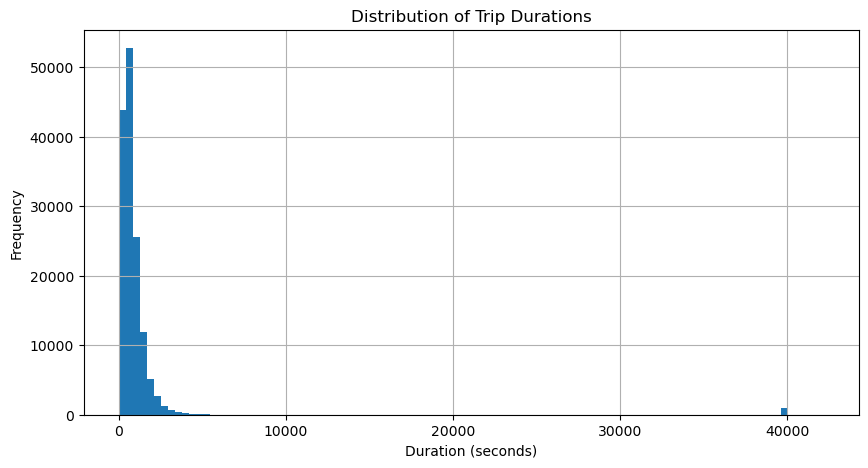

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(train['duration'], bins=100)
plt.title("Distribution of Trip Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [14]:
q1 = train['duration'].quantile(0.25)
q3 = train['duration'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

Lower bound: -575.0
Upper bound: 1977.0


In [15]:
outliers = train[(train['duration'] < lower_bound) | (train['duration'] > upper_bound)]
outlier_share = outliers.shape[0] / train.shape[0]
print(f"Share of trips with duration outliers: {outlier_share:.2f}")

Share of trips with duration outliers: 0.05


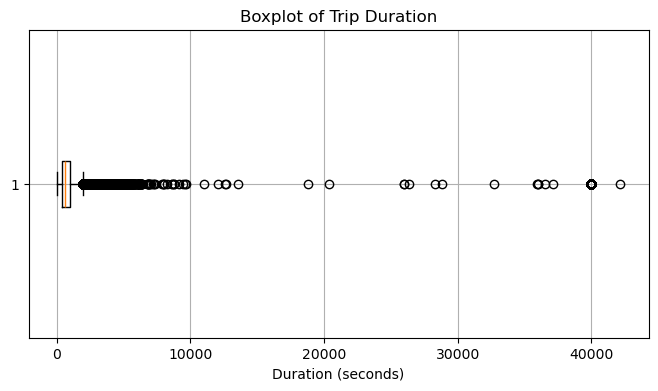

In [16]:
plt.figure(figsize=(8, 4))
plt.boxplot(train['duration'], vert=False)
plt.title("Boxplot of Trip Duration")
plt.xlabel("Duration (seconds)")
plt.grid()
plt.show()


Number of rows before removing outliers: 146001
Number of rows after removing outliers: 138038


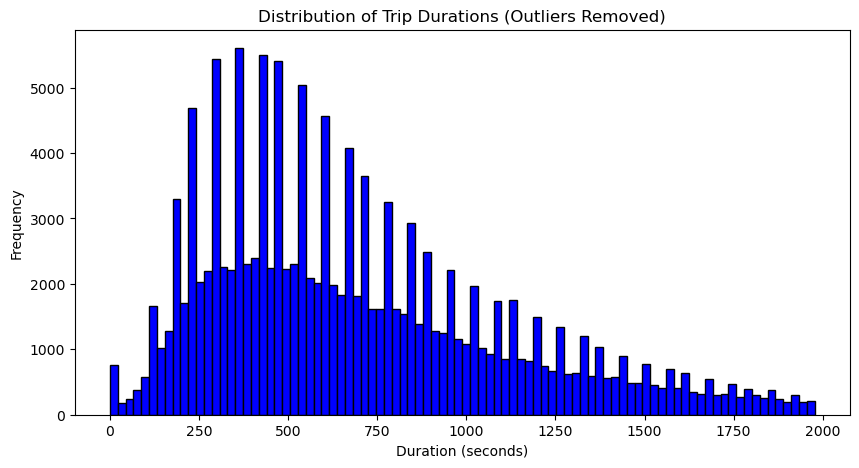

In [17]:
train_no_outliers = train[(train['duration'] >= lower_bound) & (train['duration'] <= upper_bound)]

print("\nNumber of rows before removing outliers:", train.shape[0])
print("Number of rows after removing outliers:", train_no_outliers.shape[0])

plt.figure(figsize=(10, 5))
plt.hist(train_no_outliers['duration'], bins='auto', color='blue', edgecolor='black')
plt.title("Distribution of Trip Durations (Outliers Removed)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()


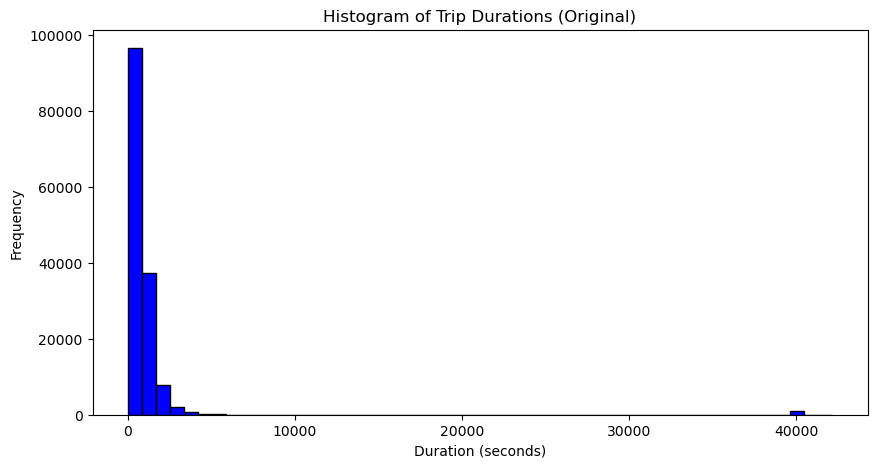

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(train['duration'], bins=50, color='blue', edgecolor='black')
plt.title("Histogram of Trip Durations (Original)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

In [19]:
duration_skew = skew(train['duration'])
print("Skewness of original duration:", duration_skew)

Skewness of original duration: 11.278690438897375


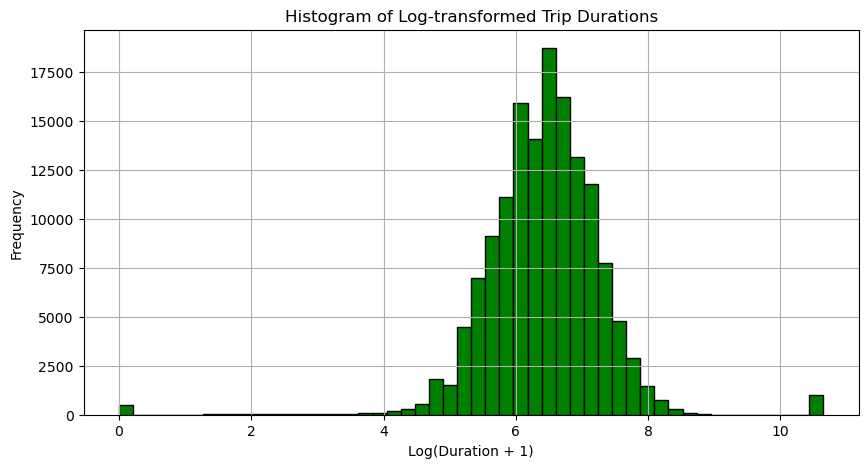

In [20]:
log_duration = np.log1p(train['duration'])

plt.figure(figsize=(10, 5))
plt.hist(log_duration, bins=50, color='green', edgecolor='black')
plt.title("Histogram of Log-transformed Trip Durations")
plt.xlabel("Log(Duration + 1)")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [21]:
log_duration_skew = skew(log_duration)
print("Skewness of log-transformed duration:", log_duration_skew)

Skewness of log-transformed duration: -0.8466758544086616


There is a difference in skewness, but we'll check that with the residuals later.

The residuals appear skewed, violating the normality assumption. This can happen if the relationship we are trying to model is non-linear.

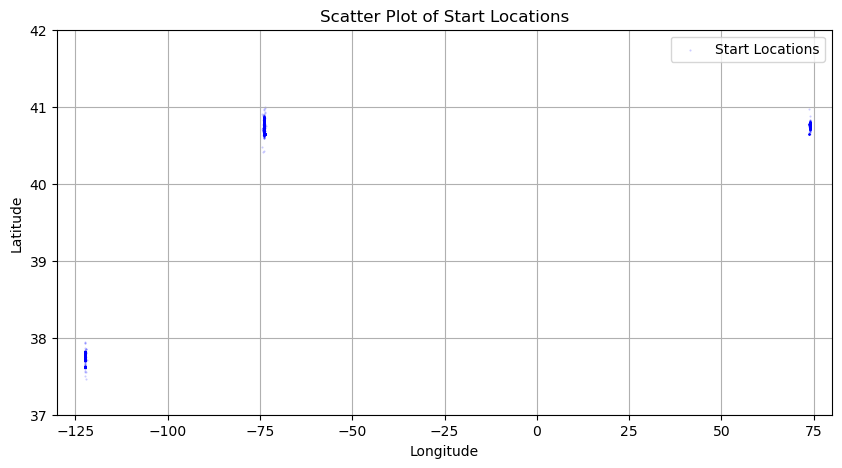

In [22]:
plt.figure(figsize=(10, 5))
plt.scatter(train['start_lng'], train['start_lat'], color='blue', label='Start Locations', marker='.', s=1, alpha=0.2)
plt.title("Scatter Plot of Start Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.xlim([-130,80])
plt.ylim([37,42])
plt.grid()
plt.show()

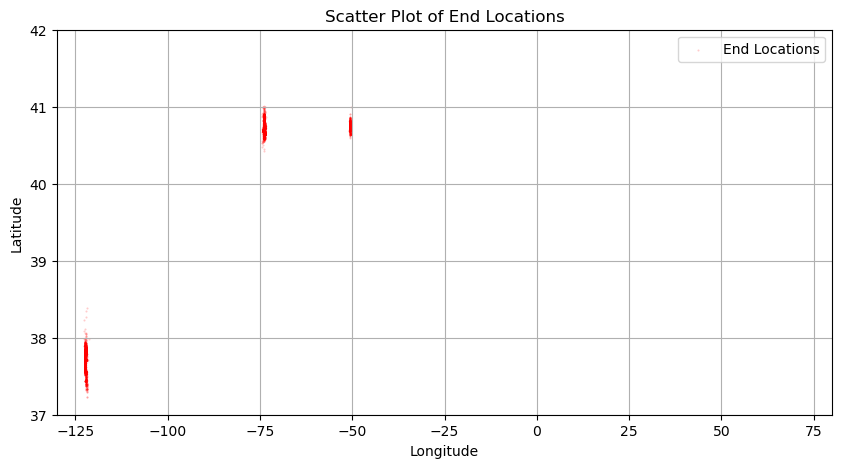

In [23]:
plt.figure(figsize=(10, 5))
plt.scatter(train['end_lng'], train['end_lat'], color='red', label='End Locations', marker='.', s=1, alpha=0.2)
plt.title("Scatter Plot of End Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.xlim([-130,80])
plt.ylim([37,42])
plt.grid()
plt.show()

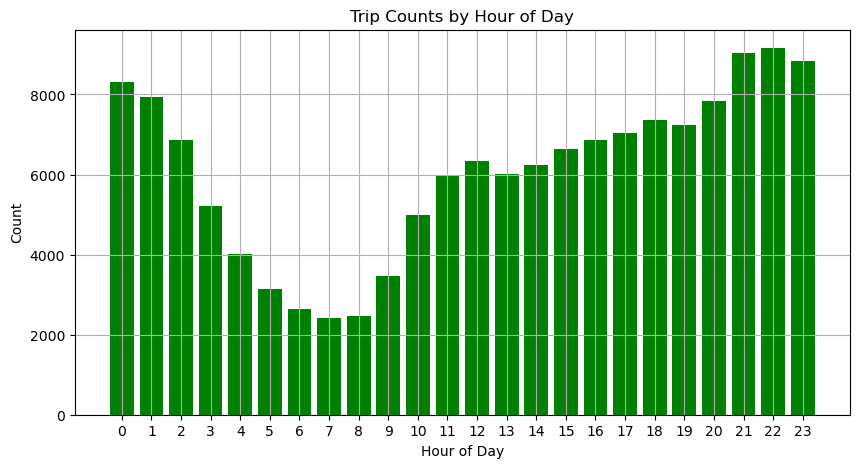

In [24]:
train['hour'] = train['datetime'].dt.hour
hour_counts = train['hour'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(hour_counts.index, hour_counts.values, color='green')
plt.title("Trip Counts by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.xticks(range(0, 24))
plt.grid()
plt.show()

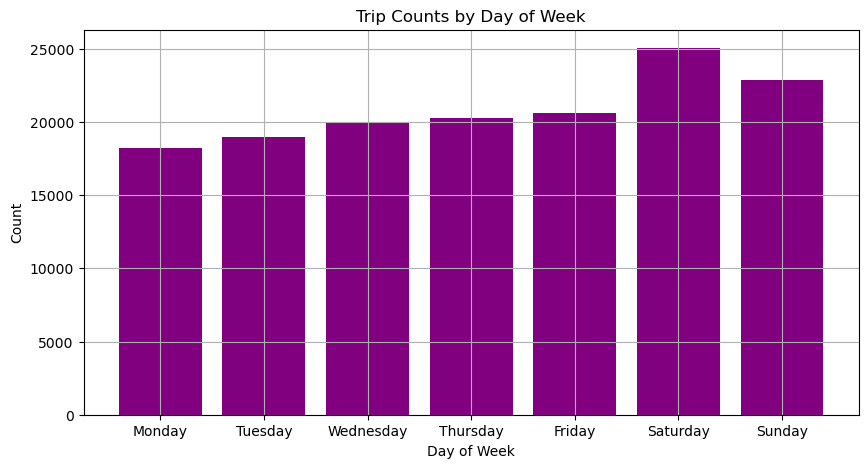

In [25]:
train['dayofweek'] = train['datetime'].dt.dayofweek
day_counts = train['dayofweek'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(day_counts.index, day_counts.values, color='purple')
plt.title("Trip Counts by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.xticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid()
plt.show()

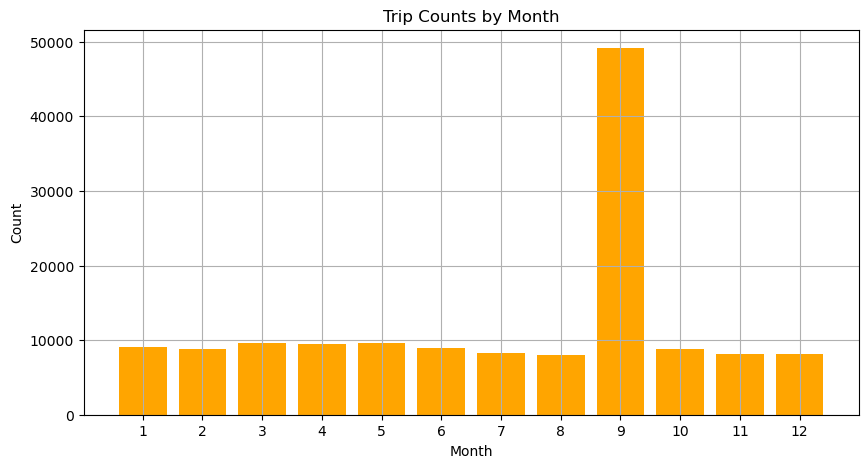

In [26]:
train['month'] = train['datetime'].dt.month
month_counts = train['month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(month_counts.index, month_counts.values, color='orange')
plt.title("Trip Counts by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.xticks(range(1, 13))
plt.grid()
plt.show()

In [27]:
train.drop(columns=['hour', 'dayofweek', 'month'], inplace=True)

# 3. Data Cleaning and Preprocessing

In this step, we ensure that our data is clean and consistent before moving forward with feature engineering and model training.

## Removing Duplicates

- Duplicate rows can bias model training. We remove any duplicated entries.

In [28]:
print("Initial training data shape:", train.shape)
train = train.drop_duplicates()
print("After removing duplicates:", train.shape)

Initial training data shape: (146001, 8)
After removing duplicates: (146001, 8)


## Handling Missing Values  
- For critical features like `start_lng`, `start_lat`, `end_lng`, and `end_lat`, missing values are not acceptable. Rows with missing values in these columns are dropped. (For non-critical columns or if missingness is higher, consider imputation strategies.)
- In the Missing Values Analysis step, we observed the distribution of missing values between the complete data and the missing data. Since the distribution is similar and the share of missing values is small, dropping rows with missing values is a reasonable approach.

In [29]:
train.dropna(subset=['start_lng', 'start_lat', 'end_lng', 'end_lat'], inplace=True)

## Removing duration equal to zero

- We remove rows where the duration is zero, as these entries are likely erroneous or incomplete.

In [30]:
train = train[train['duration'] > 0]

## Outlier Detection and Removal  
- Outliers in the `duration` field (e.g., durations that fall significantly outside the typical range) can adversely affect the model. We apply the Interquartile Range (IQR) method to detect and remove extreme values.

In [31]:
# !!!! To be completed

# 4. Feature Engineering

- In this step, we transform the raw data into more informative features that can enhance the predictive power of our models.

## Geospatial Features
- Haversine Distance: Calculates the great-circle distance between the start and end coordinates. This feature captures the physical distance traveled.
- Bearing: Computes the directional angle from the start point to the end point, which might capture travel dynamics related to road networks.

In [32]:
R = 6371

def compute_haversine(row):
    start = np.radians([row['start_lat'], row['start_lng']])
    end = np.radians([row['end_lat'], row['end_lng']])
    distance_rad = haversine_distances([start], [end])
    return distance_rad[0][0] * R

geod = Geod(ellps='WGS84')

def compute_bearing(row):
    azimuth, _, _ = geod.inv(row['start_lng'], row['start_lat'], row['end_lng'], row['end_lat'])
    return (azimuth + 360) % 360

train['distance_km'] = train.apply(compute_haversine, axis=1)
train['bearing'] = train.apply(compute_bearing, axis=1)

test['distance_km'] = test.apply(compute_haversine, axis=1)
test['bearing'] = test.apply(compute_bearing, axis=1)

## Temporal Features:
- Hour of Day: Extracted from the datetime to capture peak and off-peak travel times.
- Day of Week: Helps identify weekly patterns in travel behavior.
- Month: Can capture seasonal variations in travel times.
- Given the cyclical nature of time (e.g., 23:00 is closer to 00:00 than to 20:00), we encode these features using sine and cosine transformations to preserve their cyclical nature.

In [33]:
train['hour'] = train['datetime'].dt.hour
train['day_of_week'] = train['datetime'].dt.dayofweek
train['month'] = train['datetime'].dt.month

test['hour'] = test['datetime'].dt.hour
test['day_of_week'] = test['datetime'].dt.dayofweek
test['month'] = test['datetime'].dt.month

In [34]:
def cyclical_transform(series, period):
    sin_component = np.sin(2 * np.pi * series / period)
    cos_component = np.cos(2 * np.pi * series / period)
    return pd.DataFrame({f'{series.name}_sin': sin_component, f'{series.name}_cos': cos_component})

hour_cyclical = cyclical_transform(train['hour'], 24)
day_cyclical = cyclical_transform(train['day_of_week'], 7)
month_cyclical = cyclical_transform(train['month'], 12)

train = pd.concat([train, hour_cyclical, day_cyclical, month_cyclical], axis=1)

hour_cyclical_test = cyclical_transform(test['hour'], 24)
day_cyclical_test = cyclical_transform(test['day_of_week'], 7)
month_cyclical_test = cyclical_transform(test['month'], 12)

test = pd.concat([test, hour_cyclical_test, day_cyclical_test, month_cyclical_test], axis=1)

In [35]:
# train = train[['distance_km', 'bearing', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'duration']]
# test = test[['distance_km', 'bearing', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']]

In [36]:
train.columns

Index(['row_id', 'start_lng', 'start_lat', 'end_lng', 'end_lat', 'datetime',
       'duration', 'missing_coords', 'distance_km', 'bearing', 'hour',
       'day_of_week', 'month', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos'],
      dtype='object')

# 5. Feature Selection and Dimensionality Reduction

In this step, we evaluate our engineered and raw features to identify those that are most predictive of the target (trip duration) and remove redundant or non-informative variables.

In [37]:
features = ['start_lng', 'start_lat', 'end_lng', 'end_lat', 'distance_km', 'bearing',
             'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']

X = train[features]
y = train['duration']

## Correlation Analysis:  
- We compute a correlation matrix to assess linear relationships among the features and with the target variable. This helps us spot multicollinearity and understand which features are most strongly associated with trip duration.

In [38]:
corr_matrix = train[features + ['duration']].corr()

print("Correlation of features with target (duration):")
print(corr_matrix['duration'].sort_values(ascending=False))

Correlation of features with target (duration):
duration           1.000000
end_lat            0.071682
start_lat          0.071577
end_lng            0.070200
start_lng          0.059954
month_sin          0.043781
day_of_week_sin    0.016504
month_cos          0.000160
bearing           -0.000511
distance_km       -0.005996
day_of_week_cos   -0.008634
hour_cos          -0.010680
hour_sin          -0.011524
Name: duration, dtype: float64


In [39]:
corr_matrix

,start_lng,start_lat,end_lng,end_lat,distance_km,bearing,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,duration
start_lng,1.000000,0.876291,0.867258,0.876157,0.523573,-0.077886,0.000656,0.006467,0.059324,-0.034843,0.534284,-0.006163,0.059954
start_lat,0.876291,1.000000,0.990215,0.999476,0.072319,-0.170879,0.002178,0.005644,0.067726,-0.040701,0.610099,-0.008232,0.071577
end_lng,0.867258,0.990215,1.000000,0.990124,0.108637,-0.179984,0.002857,0.005720,0.067089,-0.040462,0.604459,-0.009170,0.070200
end_lat,0.876157,0.999476,0.990124,1.000000,0.072223,-0.171612,0.000491,0.006480,0.067671,-0.040609,0.609963,-0.008239,0.071682
distance_km,0.523573,0.072319,0.108637,0.072223,1.000000,0.101333,-0.003857,0.001528,0.004463,-0.002937,0.043500,0.000283,-0.005996
bearing,-0.077886,-0.170879,-0.179984,-0.171612,0.101333,1.000000,-0.060259,-0.021927,-0.001186,0.012238,-0.098008,0.001207,-0.000511
hour_sin,0.000656,0.002178,0.002857,0.000491,-0.003857,-0.060259,1.000000,0.032768,-0.061894,-0.007906,0.004728,0.000826,-0.011524
hour_cos,0.006467,0.005644,0.005720,0.006480,0.001528,-0.021927,0.032768,1.000000,-0.082404,-0.014643,0.004975,0.020765,-0.010680
day_of_week_sin,0.059324,0.067726,0.067089,0.067671,0.004463,-0.001186,-0.061894,-0.082404,1.000000,-0.011313,0.033795,-0.015936,0.016504
day_of_week_cos,-0.034843,-0.040701,-0.040462,-0.040609,-0.002937,0.012238,-0.007906,-0.014643,-0.011313,1.000000,-0.026070,-0.005258,-0.008634


<Figure size 1000x800 with 0 Axes>

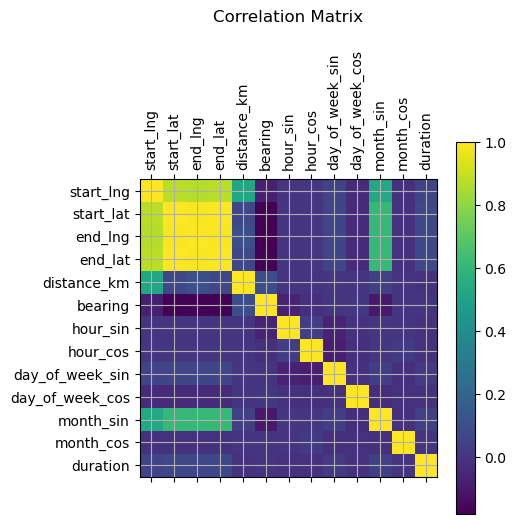

In [40]:
plt.figure(figsize=(10, 8))
plt.matshow(corr_matrix)#, fignum=1)
plt.title("Correlation Matrix", pad=20)
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.grid()
plt.show()

In [41]:
features = ['end_lng', 'end_lat', 'distance_km', 'bearing',
             'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos']

X = train[features]

In [42]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

print("\nFeature Importances from Random Forest:")
print(feature_importance)


Feature Importances from Random Forest:
distance_km        0.234987
end_lat            0.194117
bearing            0.193799
end_lng            0.183053
hour_cos           0.038903
hour_sin           0.036834
month_sin          0.033689
month_cos          0.032747
day_of_week_sin    0.030067
day_of_week_cos    0.021803
dtype: float64


## Model-Based Feature Importance:  
- A tree-based model (Random Forest) is used to estimate feature importance scores. These scores indicate how much each feature contributes to reducing the prediction error.

## Dimensionality Reduction (Optional):  
- If the feature space is high-dimensional or exhibits multicollinearity, techniques like Principal Component Analysis (PCA) can be applied to reduce the dimensionality while preserving most of the variance.

In [43]:
# FEATURE NORMALIZATION????

# Step 6: Progressive Model Selection

In this step, we start with a simple baseline model and progressively try more complex models if the initial performance is unsatisfactory.

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# 1)Linear Regression
# 2) Ridge Regression
# 3) Lasso Regression
# 4) ElasticNet Regression
# 5) Bayesian Ridge Regression
# 6) Decision Tree Regression
# 7) Random Forest Regression
# 8) Gradient Boosting Regression
# 9) XGBoost Regression
# 10) LightGBM Regression
# 11) CatBoost Regression
# 12) AdaBoost Regression
# 13) HistGradientBoosting Regression
# 14) K-Nearest Neighbors Regression
# 15) Support Vector Regression (SVR)

## Baseline Model (Simple Model):  
- We begin with a basic linear regression model. This model is quick to train, easy to interpret, and provides a baseline performance level.

In [46]:
print("Evaluating Baseline Model: Linear Regression")
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
# Using negative mean squared error scoring; RMSE = sqrt(-score)
baseline_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
baseline_rmse = np.sqrt(-baseline_scores)
print(f"Baseline Linear Regression RMSE: Mean = {baseline_rmse.mean():.2f}, Std = {baseline_rmse.std():.2f}")

Evaluating Baseline Model: Linear Regression
Baseline Linear Regression RMSE: Mean = 3299.98, Std = 99.09


In [47]:
# get coefs
baseline_model.coef_

array([-1.81186887e+00,  2.14415100e+02, -4.56186710e-02,  4.81245846e-01,
       -5.00794465e+01, -4.93273073e+01,  4.49065860e+01, -3.83705282e+01,
       -1.40733297e+00,  2.43562277e+01])

## Performance Evaluation:  
- We evaluate the baseline using 5-fold cross-validation with RMSE as the metric. This gives us an indication of whether a more complex model is needed.

## Progressive Complexity:  
- If the baseline model's performance is not acceptable, we can then try more sophisticated models, such as Random Forests, SVR, or Neural Networks. These models can capture non-linearities and interactions better but come at the cost of increased complexity and tuning effort.

In [ ]:
# If the performance is unsatisfactory, try a more complex model.
print("\nEvaluating Complex Model: Random Forest Regressor")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
# why neg mse?
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_rmse = np.sqrt(-rf_scores)
print(f"Random Forest RMSE: Mean = {rf_rmse.mean():.2f}, Std = {rf_rmse.std():.2f}")


Evaluating Complex Model: Random Forest Regressor
Random Forest RMSE: Mean = 3705.48, Std = 82.28


In [ ]:
test = test[features]

,end_lng,end_lat,distance_km,bearing,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,-73.962097,40.764500,5.401617,37.998379,-0.258819,0.965926,-0.974928,-0.222521,1.224647e-16,-1.000000e+00
1,-122.428070,37.777023,2.307671,82.123188,0.258819,0.965926,0.000000,1.000000,-1.000000e+00,-1.836970e-16
2,-73.789917,40.646965,19.580248,126.279831,0.258819,-0.965926,-0.974928,-0.222521,-1.000000e+00,-1.836970e-16
3,-122.430198,37.759545,2.970366,225.938150,0.965926,0.258819,0.000000,1.000000,-1.000000e+00,-1.836970e-16
4,-73.872711,40.774292,10.089007,74.612030,0.707107,-0.707107,0.433884,-0.900969,8.660254e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...
29995,-74.005150,40.751530,1.781467,251.323069,-0.866025,0.500000,0.433884,-0.900969,1.000000e+00,6.123234e-17
29996,-73.783386,40.648930,20.040502,126.389113,-0.965926,-0.258819,0.000000,1.000000,-8.660254e-01,-5.000000e-01
29997,-73.974182,40.791790,0.963948,209.287238,-0.866025,-0.500000,-0.433884,-0.900969,1.000000e+00,6.123234e-17
29998,-73.982063,40.774445,4.377809,30.964731,0.965926,0.258819,0.000000,1.000000,-1.000000e+00,-1.836970e-16


In [ ]:
from sklearn.model_selection import cross_val_predict
# use baseline_model to predict values for test set
predictions = rf_model.predict(test)
with open('predictions.csv', 'w') as f:
    f.write("row_id,duration\n")
    for i, duration in enumerate(predictions):
        f.write(f"{i},{duration}\n")

TypeError: BaseForest.fit() missing 1 required positional argument: 'y'